In [1]:
# Import required Python packages.

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'


In [2]:
STATE_CSV = DATA / 'state.csv'

In [5]:
# Load CSV into dataframe
state_df = pd.read_csv(STATE_CSV)
print(state_df.describe())
state_df.head(10)


         Population  Murder.Rate
count  5.000000e+01    50.000000
mean   6.162876e+06     4.066000
std    6.848235e+06     1.915736
min    5.636260e+05     0.900000
25%    1.833004e+06     2.425000
50%    4.436370e+06     4.000000
75%    6.680312e+06     5.550000
max    3.725396e+07    10.300000


,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA
5,Colorado,5029196,2.8,CO
6,Connecticut,3574097,2.4,CT
7,Delaware,897934,5.8,DE
8,Florida,18801310,5.8,FL
9,Georgia,9687653,5.7,GA


## Location
- Mean
- Weighted mean
- Median
- Percentile
- Weighted median
- Trimmed mean

### Mean, trimmed mean and median

In [8]:
pop_mean = state_df['Population'].mean() # Using pandas mean()
pop_trimmed_mean = trim_mean(state_df['Population'],0.1) # Using scipy.stat trim_mean(). Remove 10 % of the top and bottom values
median = state_df['Population'].median()

print("The mean is: ", pop_mean)
print("The trimmed mean is: ", pop_trimmed_mean)
print("The median is: ", median)

The mean is:  6162876.3
The trimmed mean is:  4783697.125
The median is:  4436369.5


### Weighted mean and weighted median

In [12]:
w_mean = np.average(state_df['Murder.Rate'],weights=state_df['Population'] ) # Available through Numpy
w_median = wquantiles.median(state_df['Murder.Rate'], weights=state_df['Population']) # Available through Wquantiles

print(f"The national mean murder rate is {w_mean:.2f}, and the national median murder rate is {w_median}.")

The national mean murder rate is 4.45, and the national median murder rate is 4.4.


## Estimates of Variability
Estimates based on variability 
- variance
- standard deviation
- mean absolute deviation from the median

... and estimates based on spread:
- range
- percentiles

In [18]:
# Pandas supplies methods for standard deviation and interquartile range (iqr)
std = state_df['Population'].std()
iqr = state_df['Population'].quantile(0.75)-state_df['Population'].quantile(0.25)

# Mean absolute deviation (MAD) = robust.scale.mad from the statsmodels package
mad = robust.scale.mad(state_df['Population'])

print(f"Population standard deviation: {std:.2f}")
print(f"Population interquartile range: {iqr:.2f}")
print(f"Population mean absolute deviation: {mad:.2f}")

Population standard deviation: 6848235.35
Population interquartile range: 4847308.00
Population mean absolute deviation: 3849876.15


In [34]:
def get_variability(data):
    try:
        std = std = data.std()
        iqr = data.quantile(0.75)-data.quantile(0.25)
        mad = robust.scale.mad(data)
    except Exception as e:
        print("Oops! We threw an error: ",e )
        return None
    return std,iqr,mad

pop_std, pop_iqr, pop_mad = get_variability(state_df['Population'])

In [35]:
print(f"The population standard deviation is {pop_std:.2f}, the interquartile range is {pop_iqr:.2f}, and the mean absolute deviation is {pop_mad:.2f}")

The population standard deviation is 6848235.35, the interquartile range is 4847308.00, and the mean absolute deviation is 3849876.15


## Exploring the Data Distribution
### Percentiles and Boxplots
The `quantile` function in pandas is quite handy in calculating percentiles, eg:

In [38]:
state_df['Murder.Rate'].quantile([0.05,0.25,0.5,0.75,0.95])

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64

Let's prettify the table by assigning it to a dataframe, add an index of percentile values and shift rows/columns (`transpose`):

In [45]:
percentages = [0.05,0.25,0.5,0.75,0.95]
df = pd.DataFrame(state_df['Murder.Rate'].quantile(percentages))
df.index=[f'{p*100} %' for p in percentages]
print("Murder rate percentiles")
print("="*60)
print(df.transpose())

Murder rate percentiles
             5.0 %  25.0 %  50.0 %  75.0 %  95.0 %
Murder.Rate    1.6   2.425     4.0    5.55    6.51


... and wrap it up in a function:

In [55]:
def print_percentiles(data,percentages):
    try:
        df = pd.DataFrame(data.quantile(percentages))
        df.index = [f'{p*100} %' for p in percentages]
    except Exception as e:
        print("Oops! We threw an error: ",e)
        return None
    print(df.columns[0],"percentiles")
    print("="*80)
    print(df.transpose())
    print("="*80)
    print("\n")
    return df,df.transpose()

data1=state_df["Murder.Rate"]
data2=state_df["Population"]
data3=state_df["State"] # Throws an error
print_percentiles(data1,percentages)
print_percentiles(data2,percentages)
print_percentiles(data3,percentages)

Murder.Rate percentiles
             5.0 %  25.0 %  50.0 %  75.0 %  95.0 %
Murder.Rate    1.6   2.425     4.0    5.55    6.51


Population percentiles
               5.0 %      25.0 %     50.0 %      75.0 %      95.0 %
Population  689529.0  1833004.25  4436369.5  6680312.25  19118545.6


Oops! We threw an error:  can't multiply sequence by non-int of type 'float'


### Boxplot
A boxplot visualizes the distribution

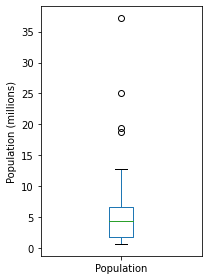

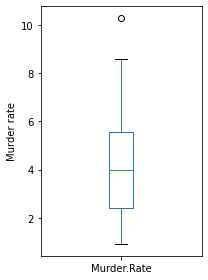

In [62]:
ax = (state_df['Population']/1_000_000).plot.box(figsize=(3,4))
ax.set_ylabel("Population (millions)")
plt.tight_layout()
plt.show()

ax = (state_df['Murder.Rate']).plot.box(figsize=(3,4))
ax.set_ylabel("Murder rate")
plt.tight_layout()
plt.show()

### Frequency Tables and Histograms
The function `pandas.cut` creates a series that maps the values into the segments. Using the method `value_counts`, we get the frequency table:

In [66]:
binned_population = pd.cut(state_df["Population"],10)
# print(binned_population) #Prints the bin assigned to each state
# What we actually want, is the value_counts():
print(binned_population.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


Prettify by assigning to dataframe and add more descriptive information

In [69]:
binned_population.name = 'binned_population'
# Concatenate state_df and binned_population to add the bin for each state in a new dataframe
df = pd.concat([state_df,binned_population], axis=1)
df

,State,Population,Murder.Rate,Abbreviation,binned_population
0,Alabama,4779736,5.7,AL,"(4232659.0, 7901692.0]"
1,Alaska,710231,5.6,AK,"(526935.67, 4232659.0]"
2,Arizona,6392017,4.7,AZ,"(4232659.0, 7901692.0]"
3,Arkansas,2915918,5.6,AR,"(526935.67, 4232659.0]"
4,California,37253956,4.4,CA,"(33584923.0, 37253956.0]"
5,Colorado,5029196,2.8,CO,"(4232659.0, 7901692.0]"
6,Connecticut,3574097,2.4,CT,"(526935.67, 4232659.0]"
7,Delaware,897934,5.8,DE,"(526935.67, 4232659.0]"
8,Florida,18801310,5.8,FL,"(15239758.0, 18908791.0]"
9,Georgia,9687653,5.7,GA,"(7901692.0, 11570725.0]"


In [80]:
# Make a list of dictionarys for each bin
groups = []

for group, subset in df.groupby(by='binned_population'):
    groups.append({
        'BinRange':group,
        'Count':len(subset),
        'State':','.join(subset.Abbreviation)
    })

# Assign to dataframe
groups_df = pd.DataFrame(groups)

# Display both list of dicts and dataframe for confirmation
display(groups)
display(groups_df)

[{'BinRange': Interval(526935.67, 4232659.0, closed='right'),
  'Count': 24,
  'State': 'AK,AR,CT,DE,HI,ID,IA,KS,ME,MS,MT,NE,NV,NH,NM,ND,OK,OR,RI,SD,UT,VT,WV,WY'},
 {'BinRange': Interval(4232659.0, 7901692.0, closed='right'),
  'Count': 14,
  'State': 'AL,AZ,CO,IN,KY,LA,MD,MA,MN,MO,SC,TN,WA,WI'},
 {'BinRange': Interval(7901692.0, 11570725.0, closed='right'),
  'Count': 6,
  'State': 'GA,MI,NJ,NC,OH,VA'},
 {'BinRange': Interval(11570725.0, 15239758.0, closed='right'),
  'Count': 2,
  'State': 'IL,PA'},
 {'BinRange': Interval(15239758.0, 18908791.0, closed='right'),
  'Count': 1,
  'State': 'FL'},
 {'BinRange': Interval(18908791.0, 22577824.0, closed='right'),
  'Count': 1,
  'State': 'NY'},
 {'BinRange': Interval(22577824.0, 26246857.0, closed='right'),
  'Count': 1,
  'State': 'TX'},
 {'BinRange': Interval(26246857.0, 29915890.0, closed='right'),
  'Count': 0,
  'State': ''},
 {'BinRange': Interval(29915890.0, 33584923.0, closed='right'),
  'Count': 0,
  'State': ''},
 {'BinRange': Int

,BinRange,Count,State
0,"(526935.67, 4232659.0]",24,"AK,AR,CT,DE,HI,ID,IA,KS,ME,MS,MT,NE,NV,NH,NM,N..."
1,"(4232659.0, 7901692.0]",14,"AL,AZ,CO,IN,KY,LA,MD,MA,MN,MO,SC,TN,WA,WI"
2,"(7901692.0, 11570725.0]",6,"GA,MI,NJ,NC,OH,VA"
3,"(11570725.0, 15239758.0]",2,"IL,PA"
4,"(15239758.0, 18908791.0]",1,FL
5,"(18908791.0, 22577824.0]",1,NY
6,"(22577824.0, 26246857.0]",1,TX
7,"(26246857.0, 29915890.0]",0,
8,"(29915890.0, 33584923.0]",0,
9,"(33584923.0, 37253956.0]",1,CA


### Histogram
A histogram is a way to visualize a frequency table, with bins on the x-axis and the data count on the y-axis. 

Pandas supports histograms for data frames with the DataFrame.plot.hist method. Use the keyword argument bins to define the number of bins. The various plot methods return an axis object that allows further fine-tuning of the visualization using Matplotlib

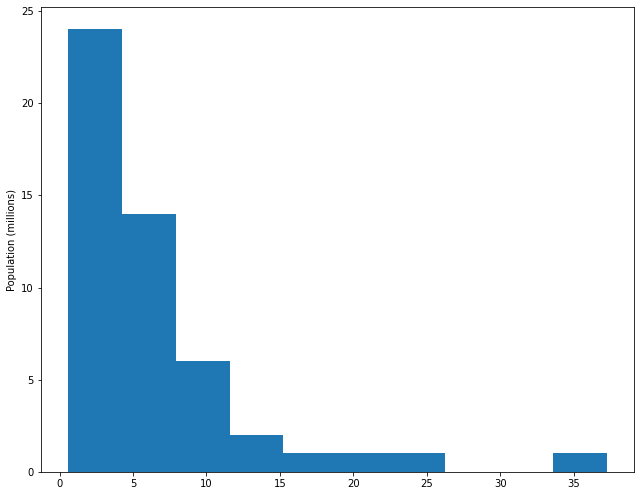

In [83]:
ax = (state_df['Population']/1_000_000).plot.hist(bins=10, figsize=(9,7))
ax.set_ylabel("Population (millions)")
plt.tight_layout()
plt.show()

>__STATISTICAL MOMENTS:__ 
In statistical theory, location and variability are referred to as the first and second moments of a distribution. The third and fourth moments are called skewness and kurtosis. Skewness refers to whether the data is skewed to larger or smaller values, and kurtosis indicates the propensity of the data to have extreme values. Generally, metrics are not used to measure skewness and kurtosis; instead, these are discovered through visual displays 

### Density Plots and Estimates
Related to the histogram is a density plot, which shows the distribution of data values as a continuous line. A density plot can be thought of as a smoothed histogram, although it is typically computed directly from the data through a kernel density estimate